<a href="https://colab.research.google.com/github/PaulFroehling/Deep-Dream/blob/main/DeepDream.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

from imageio import mimsave
from IPython.display import display as display_fn
from IPython.display import Image, clear_output
import IPython.display as display
import PIL.Image

In [27]:
def calc_loss(img, model):
  # Pass forward the image through the model to retrieve the activations.
  # Converts the image into a batch of size 1.
  img_batch = tf.expand_dims(img, axis=0)
  layer_activations = model(img_batch)
  if len(layer_activations) == 1:
    layer_activations = [layer_activations]

  losses = []
  for act in layer_activations:
    loss = tf.math.reduce_mean(act)
    losses.append(loss)

  return  tf.reduce_sum(losses)


def apply_deep_dream(image, iters=100, step_size=0.01):
  image = tf.keras.applications.inception_v3.preprocess_input(image)
  image = tf.squeeze(tf.convert_to_tensor(image))

  loss = tf.constant(0.0)
  step_size = 0.01
  step_size = tf.convert_to_tensor(step_size)
  for n in range(0,iters):
    with tf.GradientTape() as tape:
      tape.watch(image)
      loss = calc_loss(image, dream_model)
    gradients = tape.gradient(loss, image)
    gradients /= tf.math.reduce_std(gradients) + 1e-8 
    image = image + gradients*step_size
    image = tf.clip_by_value(image, -1, 1)
  
  print(str(n) +" "+str(loss))
  new_image = deprocess(image)
  display.clear_output(wait=True)
  show(new_image)
  return new_image

def deprocess(img):
  return tf.cast((255*(img +1.0)/2), tf.uint8)

def show(img):
  display.display(PIL.Image.fromarray(np.array(img)))

    

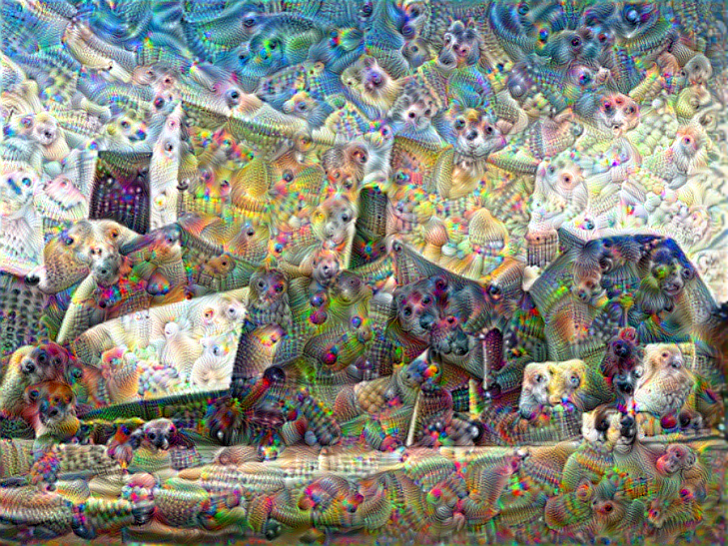

In [26]:
base_model = tf.keras.applications.InceptionV3(include_top=False, weights='imagenet')
names = ['mixed3','mixed5']
layers = [base_model.get_layer(name).output for name in names]
dream_model = tf.keras.Model(inputs=base_model.input, outputs=layers)


tf.keras.backend.clear_session()
OCTAVE_SCALE = 1.31
img = tf.constant(np.array(PIL.Image.open("images/mixed_styles.png")))
base_shape = tf.shape(img)[:-1]
float_base_shape = tf.cast(base_shape, tf.float32)

for n in range(-2, 1):
  new_shape = tf.cast(float_base_shape*(OCTAVE_SCALE**n+0.002), tf.int32)

  img = tf.image.resize(img, new_shape).numpy()

  img = apply_deep_dream(img, iters=40, step_size=0.1)

display.clear_output(wait=True)
img = tf.image.resize(imgn, base_shape)
img = tf.image.convert_image_dtype(img/255.0, dtype=tf.uint8)
show(img)